# Definition of Files

Import of Classes from `ICONProcessor` and definition of `.nc` Files to be used:
* Definition file of Grid: `<area>_<resolution>m_DOM<nr>.nc`
* Definition of corresponding file containing external parameters (e.g. topo, albedo, land use, etc.): `external_parameter_icon_<area>_<resolution>m_DOM<nr>_<suffix>_tiles.nc`
* Definition of output file from ICON run (contain actual variables like temperature, wind, etc.): `LES_DOM01_ML_<nr>.nc`

In [1]:
from ICONProcessor.ICONGrid import ICONGrid

import geopandas as gpd
import matplotlib.pyplot as plt

## Example: Monteverde Cloud Forest (Costa Rica) study area for

The following scenarios will be used:
* 411m resolution:
    * plot topography
    * plot selected land use classes
    * plot dominant land use class for each grid cell

In [2]:
root_dir = '/Users/geoalxx/Python/_ICON_data/mv/'

file_411_grid       = root_dir + 'grid/MV411m_DOM05.nc'
file_411_extpar     = root_dir + 'grid/external_parameter_icon_MV411m_DOM05_tiles.nc'

Read country outlines from `.shp` file so they can be added to the plots.

In [3]:
gdf_border = gpd.read_file(root_dir + 'grid/grid.gpkg', layer='country_border')
display(gdf_border)

,CAT,FIPS_CNTRY,CNTRY_NAME,AREA,POP_CNTRY,name_rus,geometry
0,50,CS,Costa Rica,51100.0,3956507.0,None,"POLYGON ((-85.17111 10.12139, -85.16196 10.122..."
1,50,CS,Costa Rica,51100.0,3956507.0,None,"POLYGON ((-85.07002 10.15534, -85.22945 10.210..."


Load ICON grid from previously defined files. The method `get_triangles()` converts the rather complex ICON grid information into geometries that can be easily consumed. The resulting `GeoDateFrame` can be extended by cell-specific attributes such as topography, LU fraction, etc.

The next cell derives and plots the topography of the grid cells.

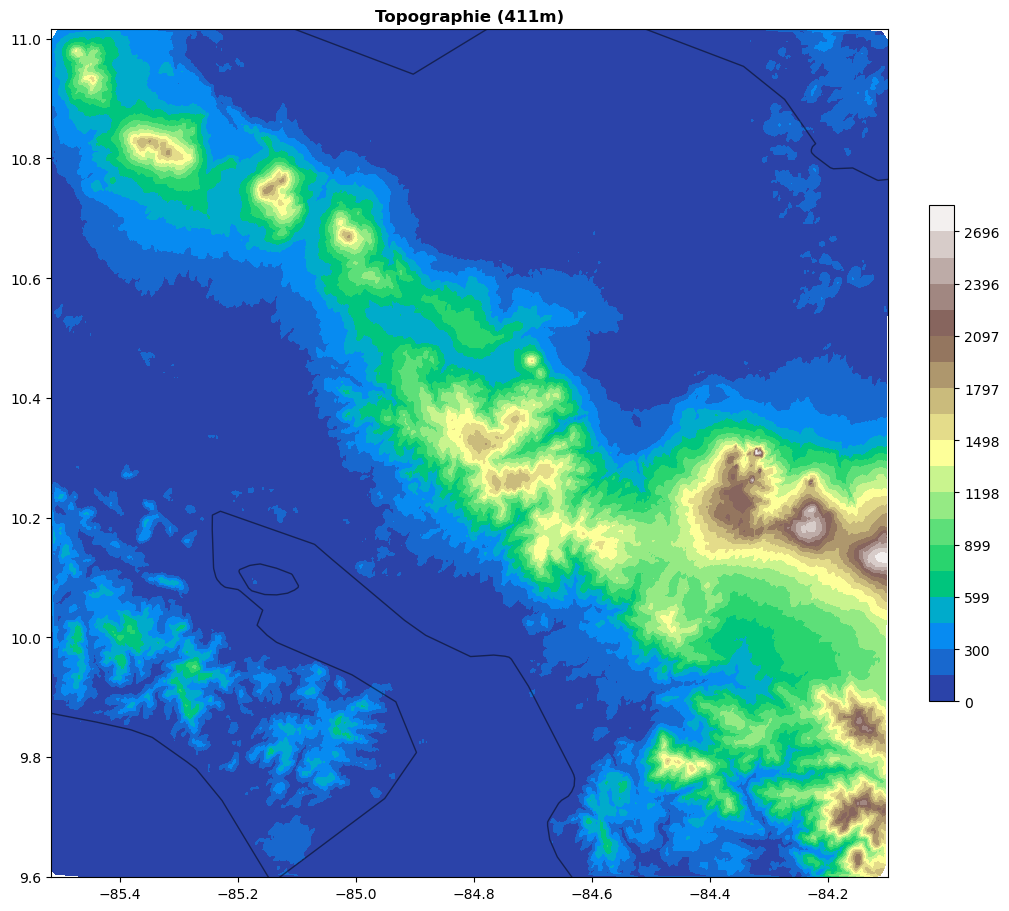

In [4]:
grid_411 = ICONGrid(file_411_grid, file_411_extpar)
gdf = grid_411.get_triangles()
gdf['topo'] = grid_411.get_topo()
grid_411.plot_single(gdf,'topo','Topographie (411m)', outlines=gdf_border, cmap='terrain')


With in the `ext_par`file for each grid, the LU class fractions of each cell are defined, i.e. each cell consists of an 1D-array with `size=23`. Present LU classes have a value between `0 < x ≤ 1`. The sum of all LU class fractions must be equal to 1. The names of the LU classes are listed below.

Example:

`[0, 0.6, 0, 0, 0.4, ... 0]` -> 60% of the cell area is 'rainfed cropland', 40% is 'closed broadleaved evergreen forest'

**Hint**: low resolution grids tend to have multiple LU classes within one cell (fractures). High resolution grids have mostly only one dominant LU class with value 1 (100%).


In [5]:
lu_names = grid_411.get_lu_class_name()
for idx,val in enumerate(lu_names):
    print(idx,val)

0 irrigated croplands
1 rainfed croplands
2 mosaic cropland (50-70%) - vegetation (20-50%)
3 mosaic vegetation (50-70%) - cropland (20-50%)
4 closed broadleaved evergreen forest
5 closed broadleaved deciduous forest
6 open broadleaved deciduous forest
7 closed needleleaved evergreen forest
8 open needleleaved deciduous forest
9 mixed broadleaved and needleleaved forest
10 mosaic shrubland (50-70%) - grassland (20-50%)
11 mosaic grassland (50-70%) - shrubland (20-50%)
12 closed to open shrubland
13 closed to open herbaceous vegetation
14 sparse vegetation
15 closed to open forest regularly flooded
16 closed forest or shrubland permanently flooded
17 closed to open grassland regularly flooded
18 artificial surfaces
19 bare areas
20 water bodies
21 permanent snow and ice
22 undefined


Now let's create an ensemble of LU classes. Each plot shows a selected LU class and its fraction for each cell. Since the resolution is fairly high, the result is mostly binary (0 or 1). The darker the color, the higher the LU class fraction of the cell.

Processing LU class: rainfed croplands
Processing LU class: mosaic cropland (50-70%) - vegetation (20-50%)
Processing LU class: mosaic vegetation (50-70%) - cropland (20-50%)
Processing LU class: closed broadleaved evergreen forest
Processing LU class: closed to open herbaceous vegetation
Processing LU class: water bodies


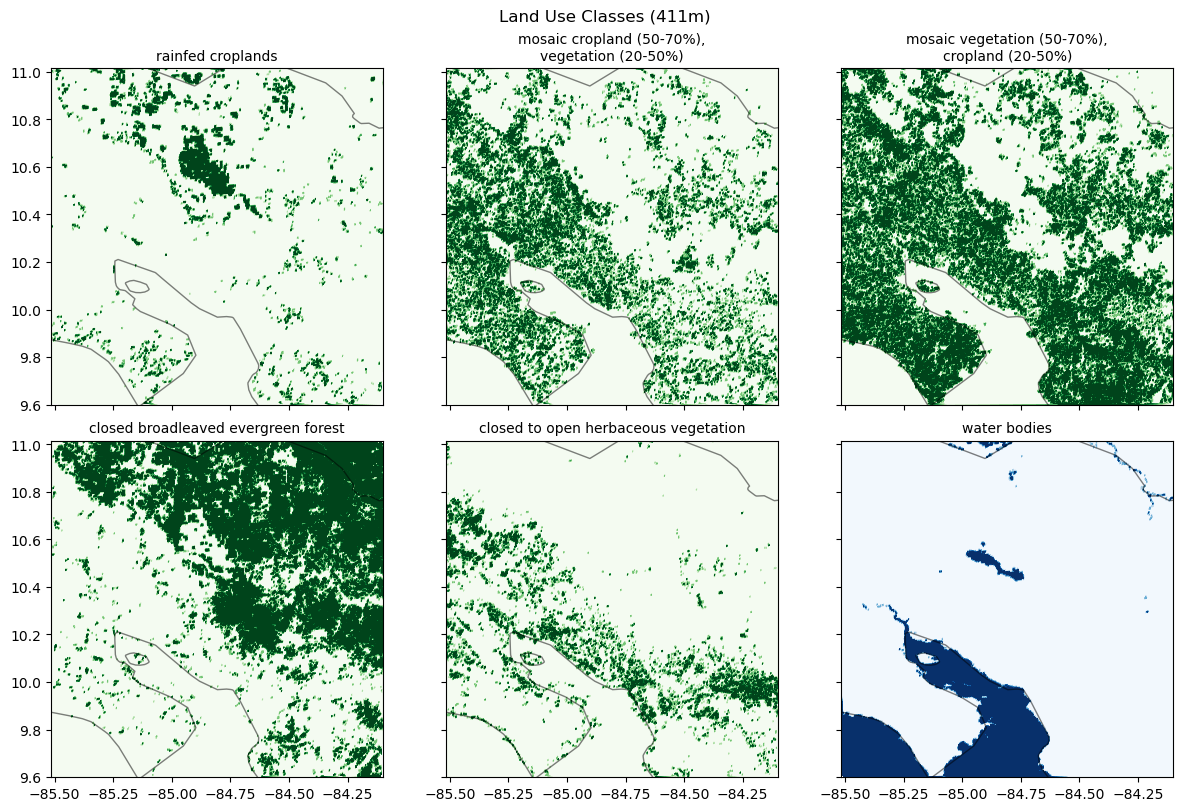

In [6]:
fig, axs = plt.subplots(figsize=(12,8), sharex=True, sharey=True, ncols=3, nrows=2, constrained_layout=True)

lu_idx = [1,2,3,4,13,20] # selection of LU classes
for idx,ax in enumerate(axs.flatten()):
    title = f'{lu_names[lu_idx[idx]]}'
    print('Processing LU class:', title)
    title = title.replace(' - ',',\n')
    if lu_idx[idx] == 20:
        cmap = 'Blues'
    else:
        cmap = 'Greens'
    gdf['lu_data'] = grid_411.get_lu_fraction(lu_idx[idx])
    grid_411.plot_single(gdf, 'lu_data', title, outlines=gdf_border, cmap=cmap, ax=ax, show=False, colorbar=False, extend='both')
    ax.set_title(title, fontsize=10)

plt.suptitle('Land Use Classes (411m)')
plt.show()

The LU class with the highest fraction is determined for each grid cell. The default LU class colors correspond to the defined colors in the <a href="https://esdac.jrc.ec.europa.eu/public_path/shared_folder/dataset/GLOBCOVER_Products_Description_Validation_Report_I2.1.pdf">GLOBCOVER Products Description and Validation Report</a>. However, the colors can be adjusted to highlight certain LU classes.

**Hint**: the dominant LU classes can be plotted at all domains since LU information is derived from the `ext_par` file.

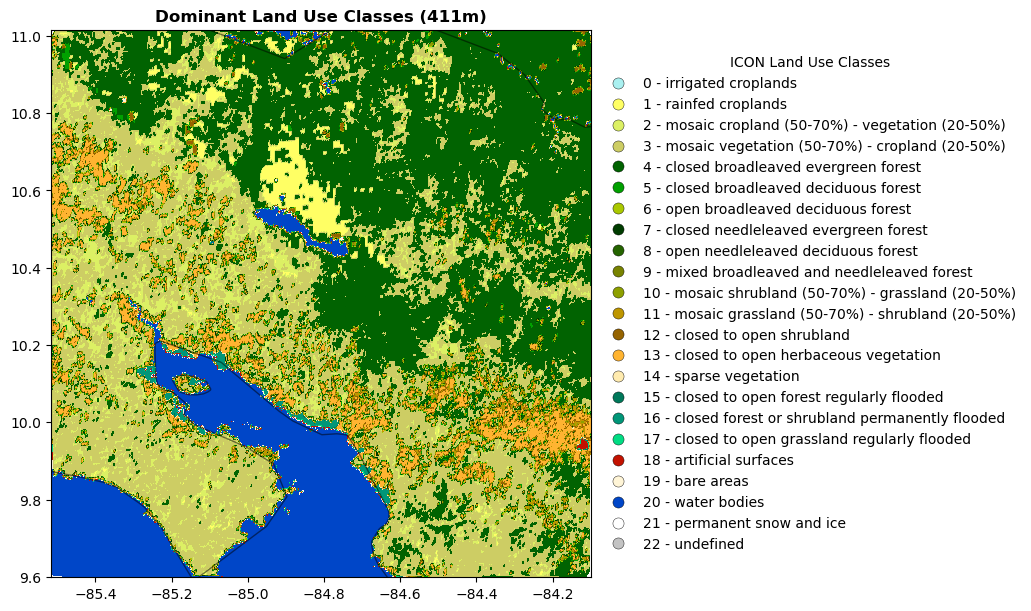

In [7]:
# change default color of water bodies to light blue
lu_colors = grid_411.get_lu_colors()
#lu_colors[20] = 'lightblue'

grid_411.plot_dominant_lu_class(title='Dominant Land Use Classes (411m)', lu_colors=lu_colors, outlines=gdf_border)